
[L] 경로 처리 시작
  > N0 처리 중...
    - 평균 거리: 678.37 (엔트리 10114개)
  > N2 처리 중...
    - 평균 거리: 685.05 (엔트리 6274개)
  > N3 처리 중...
    - 평균 거리: 684.63 (엔트리 11131개)
  > N27 처리 중...
    - 평균 거리: 690.59 (엔트리 7930개)
  > N14 처리 중...
    - 평균 거리: 686.99 (엔트리 5395개)
  > N16 처리 중...
    - 평균 거리: 699.79 (엔트리 10519개)
  > N18 처리 중...
    - 평균 거리: 693.71 (엔트리 15493개)
  > N24 처리 중...
    - 평균 거리: 694.79 (엔트리 20007개)
  > N29 처리 중...
    - 평균 거리: 681.80 (엔트리 12530개)

[P] 경로 처리 시작
  > N0 처리 중...
    - 평균 거리: 696.41 (엔트리 8359개)
  > N2 처리 중...
    - 평균 거리: 696.62 (엔트리 8026개)
  > N3 처리 중...
    - 평균 거리: 690.40 (엔트리 19160개)
  > N27 처리 중...
    - 평균 거리: 689.31 (엔트리 8367개)
  > N14 처리 중...
    - 평균 거리: 673.94 (엔트리 4221개)
  > N16 처리 중...
    - 평균 거리: 677.21 (엔트리 8662개)
  > N18 처리 중...
    - 평균 거리: 688.67 (엔트리 12460개)
  > N24 처리 중...
    - 평균 거리: 694.51 (엔트리 22074개)
  > N29 처리 중...
    - 평균 거리: 685.24 (엔트리 11481개)


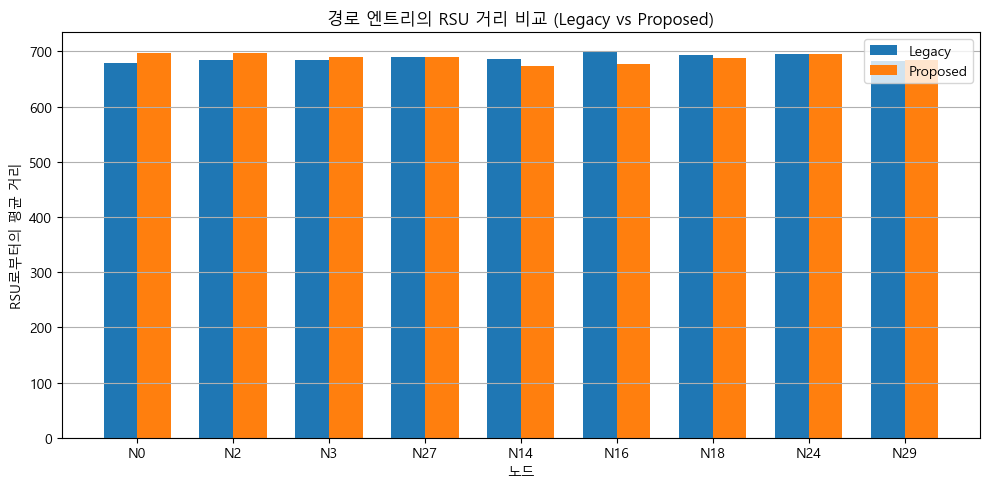

In [5]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N27", "N14", "N16", "N18", "N24", "N29"]
rsu_pos = (800.0, 600.0)
fcd_path = "resource/map5.xml"

def load_fcd_positions(path):
    tree = ET.parse(path)
    root = tree.getroot()
    fcd = {}
    for timestep in root.findall("timestep"):
        time = round(float(timestep.attrib["time"]), 1)
        pos = {}
        for v in timestep.findall("vehicle"):
            vid = int(v.attrib["id"])
            x = float(v.attrib["x"])
            y = float(v.attrib["y"])
            pos[vid] = (x, y)
        fcd[time] = pos
    return fcd

def euclidean(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def compute_avg_distances(mode):
    avg_distances = {}
    print(f"\n[{mode}] 경로 처리 시작")

    for node in nodes:
        print(f"  > {node} 처리 중...")
        path = os.path.join(base_path, mode, density, speed, node, "aodv_routing_log.csv")
        if not os.path.isfile(path):
            print(f"    - 파일 없음: {path}")
            avg_distances[node] = np.nan
            continue

        try:
            df = pd.read_csv(path)
            df["Time"] = df["Time"].round(1)
            df = df[(df["Time"] >= 30.0) & (df["Time"] <= 100.0)]
            df = df[
                (df["Previous_HopCount"] != df["New_HopCount"]) |
                (df["Previous_NextHop"] != df["New_NextHop"])
            ]
            df["NodeID"] = df["Node"].str.extract(r'(\d+)').astype(int)
            df["NextHopID"] = df["New_NextHop"].str.extract(r'(\d+)').astype(int)
        except Exception as e:
            print(f"    - CSV 파싱 실패: {e}")
            avg_distances[node] = np.nan
            continue

        distances = []
        for _, row in df.iterrows():
            t = row["Time"]
            nid = row["NodeID"]
            nhid = row["NextHopID"]
            if t in fcd_data:
                for id_ in [nid, nhid]:
                    if id_ in fcd_data[t]:
                        d = euclidean(fcd_data[t][id_], rsu_pos)
                        distances.append(d)

        if distances:
            avg_distance = np.mean(distances)
            print(f"    - 평균 거리: {avg_distance:.2f} (엔트리 {len(distances)}개)")
            avg_distances[node] = avg_distance
        else:
            print(f"    - 위치 매칭 실패 (거리 없음)")
            avg_distances[node] = np.nan

    return avg_distances


fcd_data = load_fcd_positions(fcd_path)
legacy_result = compute_avg_distances("L")
proposed_result = compute_avg_distances("P")

x = np.arange(len(nodes))
width = 0.35
legacy_vals = [legacy_result[n] for n in nodes]
proposed_vals = [proposed_result[n] for n in nodes]

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, legacy_vals, width=width, label="Legacy")
plt.bar(x + width/2, proposed_vals, width=width, label="Proposed")
plt.xticks(x, nodes)
plt.xlabel("노드")
plt.ylabel("RSU로부터의 평균 거리")
plt.title("경로 엔트리의 RSU 거리 비교 (Legacy vs Proposed)")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


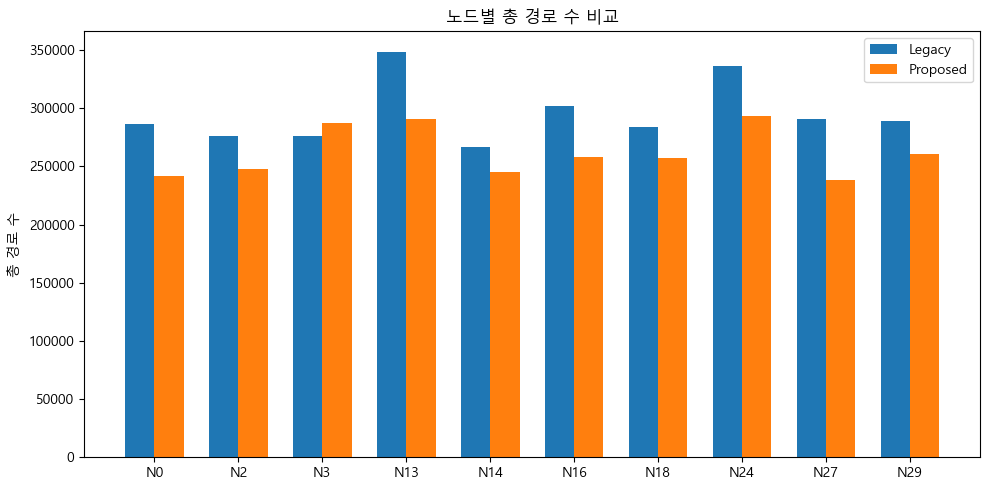

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_05_08_AppSci_AODV_V03"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N27", "N29"]

def count_routes(path):
    route_counts = []
    for node in nodes:
        file_path = os.path.join(path, node, "aodv_routing_log.csv")
        if not os.path.isfile(file_path):
            route_counts.append(0)
            continue
        df = pd.read_csv(file_path)
        route_counts.append(len(df))
    return route_counts

legacy_path = os.path.join(base_path, "L", density, speed)
proposed_path = os.path.join(base_path, "P", density, speed)

legacy_counts = count_routes(legacy_path)
proposed_counts = count_routes(proposed_path)

x = range(len(nodes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], legacy_counts, width=width, label='Legacy')
plt.bar([i + width/2 for i in x], proposed_counts, width=width, label='Proposed')
plt.xticks(x, nodes)
plt.ylabel('총 경로 수')
plt.title('노드별 총 경로 수 비교')
plt.legend()
plt.tight_layout()
plt.show()
